#### PINN (Physics Informed Neural Network) from scratch

TLDR - Use differential equation residuals as a loss function, instead of comparing sample points

#### 1D Heat Equation

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$



In [9]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Parameters
L = 1.0          # Length of the rod
T = 30          # Total time to simulate
alpha = 0.01     # Thermal diffusivity
nx = 20          # Number of spatial points
nt = 300         # Number of time steps
dx = L / (nx - 1)
dt = T / nt


# Grid
x = np.linspace(0, L, nx)
 
# Initial condition: sin(pi * x)
u = np.ones(nx)

# np.linspace(0, 1, nx)
print(u)
# Dirichlet boundary conditions
u[0] = u[-1] = 0

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


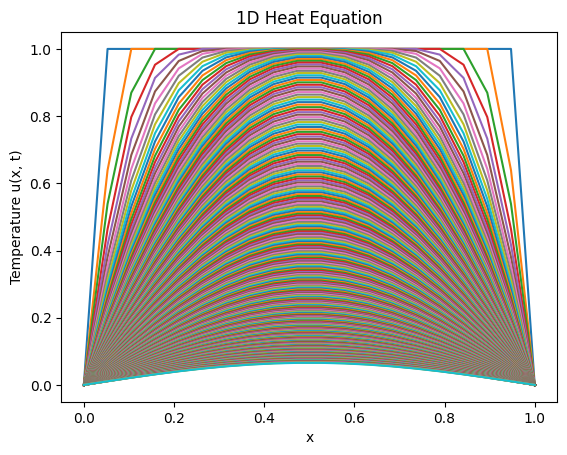

In [3]:
# Stability condition (CFL condition)
assert alpha * dt / dx**2 <= 0.5, "Stability condition violated!"

# Store solutions for visualization
u_all = [u.copy()]

# Time-stepping loop (explicit method)
for n in range(1, nt):
    u_new = u.copy()
    for i in range(1, nx - 1):
        u_new[i] = u[i] + alpha * dt / dx**2 * (u[i+1] - 2*u[i] + u[i-1])
    u = u_new
    u[0] = u[-1] = 0  # Enforce boundary conditions
    u_all.append(u.copy())

for u in u_all:
    plt.plot(x, u)
    

plt.xlabel('x')
plt.ylabel('Temperature u(x, t)')
plt.title('1D Heat Equation')
plt.show()

In [87]:
u_pred_all[0].T[0]

array([0.8220309 , 0.8613266 , 0.89795697, 0.9308131 , 0.95889103,
       0.9814129 , 0.99789953, 1.0081861 , 1.0123907 , 1.0108542 ,
       1.0040712 , 0.99262905, 0.97715497, 0.9582814 , 0.9366174 ,
       0.9127344 , 0.88715374, 0.86034226, 0.8327104 , 0.8046117 ],
      dtype=float32)

In [4]:
print(f"{nt} samples from 0-{T} seconds, {nx} spatial points from 0-{L} meters")
print(len(u_all), len(u_all[0]), "total:", len(u_all) * len(u_all[0]))

300 samples from 0-30 seconds, 20 spatial points from 0-1.0 meters
300 20 total: 6000


In [99]:
class HeatEqautionSample():
  def __init__(self, num_samples = 100, L=1.0, T=30, boundary_value = 0):
    self.num_samples = num_samples
    self.L = L
    self.T = T
    self.boundary_value = boundary_value

    self.initial_conds = self.get_initial_conds()
    self.boundary_conds = self.get_boundary_conds()

  def get_initial_conds(self, n=100):
    x = np.random.uniform(0, self.L, n)
    u_0 = np.ones_like(x)
    t = np.zeros_like(x)
    return (u_0, x, t)

  ## get all boundary conds
  def get_boundary_conds(self, n=100):
    # print(np.random.uniform(0, self.T, n))
    t = np.random.uniform(0, self.T, n)
    x = np.random.choice([0.0, self.L], size=n, replace=True)
    u_b = np.zeros_like(t)

    return (u_b, x, t)
  
  def get_samples(self):
    num_samples = self.num_samples

    sample_x = np.random.uniform(0, self.L, num_samples)
    sample_t = np.random.uniform(0, self.T, num_samples)

    return (sample_x, sample_t)
  
  def get_dataloader(self, n):
    for _ in range(n):
      x = [self.initial_conds, self.boundary_conds, self.get_samples()]
      x = [[torch.from_numpy(np.array([xi])).to(dtype=torch.float32) for xi in x_i] for x_i in x]
      yield x

In [ ]:
data = HeatEqautionSample(boundary_value=0)

for inital_conds, boundary_conds, samples in data.get_dataloader(10):
  print(boundary_conds)
  break

In [107]:
class HeatPINN(nn.Module):
    def __init__(self):
        super(HeatPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t, x):
        return self.net(torch.cat([t.T, x.T], dim=1))

In [ ]:
alpha = 0.01
num_epochs = 100

model = HeatPINN()
data = HeatEqautionSample(num_samples=1000)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

plot = []

for epoch in range(num_epochs):
  for inital_conds, boundary_conds, samples in data.get_dataloader(100):
    optimizer.zero_grad()

    # initial and boundary loss mse
    u_0, x_0, t_0 = inital_conds
    init_out_x = model(t_0, x_0)
    init_loss = torch.mean((init_out_x - u_0) ** 2)

    u_b, x_b, t_b = boundary_conds
    bound_out_x = model(t_b, x_b)
    bound_loss = torch.mean((bound_out_x - u_b) ** 2)

    ## sample loss, use residuals

    x_r, t_r = samples

    x_r.requires_grad_(), t_r.requires_grad_()

    u_r = model(t_r, x_r)
    
    u_t = torch.autograd.grad(u_r, t_r, grad_outputs=torch.ones_like(u_r), create_graph=True)[0]
    u_x = torch.autograd.grad(u_r, x_r, grad_outputs=torch.ones_like(u_r), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_r, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    res = u_t - alpha * u_xx
    loss_pde = 5 * torch.mean(res**2)
    
    
    loss = init_loss + bound_loss + loss_pde
    plot.append([loss.item(), init_loss.item(), bound_loss.item(), loss_pde.item()])
    
    loss.backward()
    optimizer.step()

  print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item()}")

In [109]:
torch.save(model.state_dict(), "models/model.ckpt")

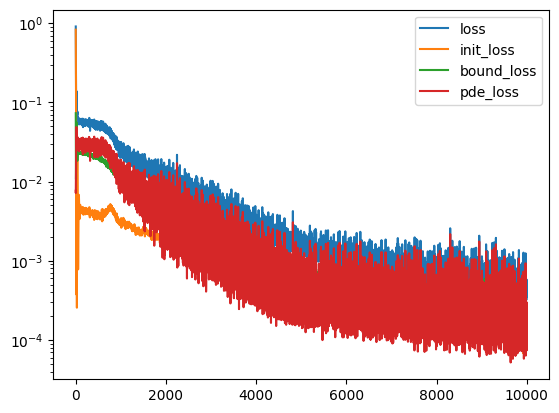

In [110]:
plot = np.array(plot)
plt.plot(plot[:, 0], label="loss")
plt.plot(plot[:, 1], label="init_loss")
plt.plot(plot[:, 2], label="bound_loss")
plt.plot(plot[:, 3], label="pde_loss")
plt.yscale('log')
plt.legend()
plt.show()

In [111]:
# Time-stepping loop (explicit method)

# Parameters
# L = 1.0          # Length of the rod
# T = 30          # Total time to simulate
# alpha = 0.01     # Thermal diffusivity
# nx = 20          # Number of spatial points
# nt = 300         # Number of time steps
# dx = L / (nx - 1)
# dt = T / nt


# # Grid
# x = np.linspace(0, L, nx)
 
# # Initial condition: sin(pi * x)
# u = np.ones(nx)

# # np.linspace(0, 1, nx)
# print(u)
# # Dirichlet boundary conditions
# u[0] = u[-1] = 0
model.eval()

time = np.linspace(0, T, nt)

u_pred_all = []

for t in time:
  x_test = np.linspace(0, L, nx)
  t_test = np.full(nx, t)

  x_test = torch.from_numpy(np.array([x_test])).to(dtype=torch.float32)
  t_test = torch.from_numpy(np.array([t_test])).to(dtype=torch.float32)

  res = model(t_test, x_test).detach().numpy().T[0]

  u_pred_all.append(res)

model.train()

HeatPINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

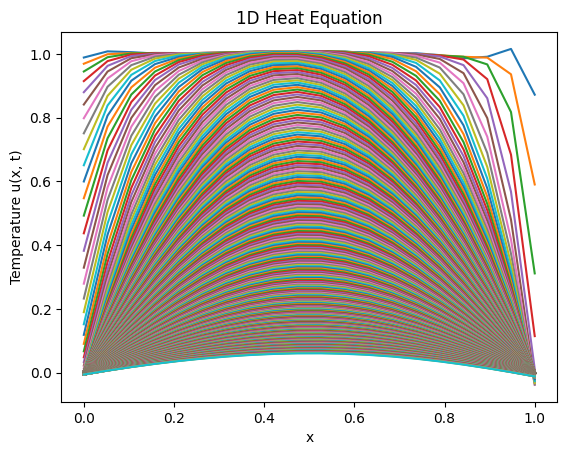

In [112]:
x = np.linspace(0, L, nx)
for u in u_pred_all:
    plt.plot(x, u)
    
    

plt.xlabel('x')
plt.ylabel('Temperature u(x, t)')
plt.title('1D Heat Equation')
plt.show()